# **AlexNet Implementation for Chest X-Ray Classification**

**Par:** *EL MHAMDI Nouha*

This notebook implements the classic **AlexNet** convolutional neural network architecture to classify Chest X-Ray images into **NORMAL** and **PNEUMONIA** categories, step-by-step explanation of the entire process, from data preparation to model training and performance analysis.


### **Environment and Hyperparameter Setup**

We import the necessary libraries (TensorFlow and Keras) and configure the environment for training.


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization, # Using BatchNormalization as a modern alternative to LRN
    Activation
)
import numpy as np
import os

# --- 1. TPU/GPU Strategy Setup ---
try:
    # Connect to TPU if available
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    # Fallback to default strategy (GPU or CPU)
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

# Global parameters
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32 * strategy.num_replicas_in_sync # Scale batch size for multi-replica training
IMAGE_SIZE = [227, 227] # AlexNet's original input size
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]
NUM_CLASSES = len(CLASS_NAMES)

print(f"Effective BATCH_SIZE: {BATCH_SIZE}")
print(f"IMAGE_SIZE: {IMAGE_SIZE}")

Number of replicas: 1
Effective BATCH_SIZE: 32
IMAGE_SIZE: [227, 227]


## **Data Loading and Preprocessing**

This section handles loading the Chest X-Ray dataset from Google Cloud Storage. The data is stored in a highly efficient format called **TFRecord**.

We define two helper functions:
1.  `get_label`: This function extracts the class label (Normal or Pneumonia) from the file path.
2.  `decode_img`: This function reads the image data, decodes it from JPEG format, resizes it to the required **227 by 227 pixels** for AlexNet, and normalizes the pixel values to be between 0 and 1.

Finally, the `process_path` function combines these steps to prepare each image and its corresponding label for the model. We then split the total dataset into a training set and a validation set.


In [2]:
# Load TFRecord datasets
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)
ds = tf.data.Dataset.zip((train_images, train_paths))

def get_label(file_path):
    # Convert the path to a list of path components
    # The label is derived from the directory name (PNEUMONIA or NORMAL)
    parts = tf.strings.split(file_path, "/")
    # The second to last part is the class-directory
    if parts[-2] == tf.constant("PNEUMONIA"):
        return 1 # PNEUMONIA
    else:
        return 0 # NORMAL

def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image to the desired size (227x227 for AlexNet)
    img = tf.image.resize(img, IMAGE_SIZE)
    # Normalize the image to [0, 1]
    return img / 255.0

def process_path(image, path):
    # Decode the image data and get the label
    label = get_label(path)
    img = decode_img(image)
    return img, label

# Apply the processing function to the dataset
ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

# Determine the total size of the dataset (needed for splitting)
DATASET_SIZE = tf.data.experimental.cardinality(ds).numpy()
if DATASET_SIZE == tf.data.experimental.UNKNOWN_CARDINALITY:
    # Fallback if cardinality is unknown (e.g., if running locally without GCS access)
    # Based on the original code's split, the total size is around 5216 (4200 + 1016)
    DATASET_SIZE = 5216 
    
TRAIN_SIZE = 4200
VAL_SIZE = DATASET_SIZE - TRAIN_SIZE

print(f"Total dataset size: {DATASET_SIZE}")
print(f"Training set size: {TRAIN_SIZE}")
print(f"Validation set size: {VAL_SIZE}")

# Shuffle, split, and batch the dataset
ds = ds.shuffle(buffer_size=10000)
train_ds = ds.take(TRAIN_SIZE)
val_ds = ds.skip(TRAIN_SIZE)

train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

Total dataset size: 5216
Training set size: 4200
Validation set size: 1016


## **3. AlexNet Model Architecture**

The model is built using the Keras Sequential API, The AlexNet model is a deep Convolutional Neural Network (CNN) known for its large filter sizes and use of pooling and normalization layers. The architecture is a sequence of layers, each performing a specific transformation on the data.. We use **Batch Normalization** as a modern, more effective alternative to the original Local Response Normalization (LRN) layers (NORM1 and NORM2), which are rarely used in modern deep learning.

The model is a sequence of layers (Sequential):


| Layer Type                         | Pedagogical Role                                                                                                                                                          | Key AlexNet Layers                |
| ---------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------- |
| Conv2D (Convolution)               | The "feature detectors." They scan the image with filters (e.g., 11x11) to identify patterns.                                                                             | CONV1, CONV2, CONV3, CONV4, CONV5 |
| MaxPooling2D (Pooling)             | Reduces the image size and the number of calculations. Makes the model more robust to slight shifts of the object in the image.                                           | MAX POOL1, MAX POOL2, MAX POOL3   |
| BatchNormalization (Normalization) | Stabilizes learning and allows for higher learning rates. This is a modern alternative to the original LRN (Local Response Normalization).                                | NORM1, NORM2                      |
| Flatten                            | Transforms the 3D output of the final convolutional block into a single, long 1D vector, ready for classification.                                                        | -                                 |
| Dense (Fully Connected Layers)     | The "decision-making" layers. They take the extracted features and combine them to make the final prediction.                                                             | FC6, FC7, FC8                     |
| Dropout                            | An essential technique to prevent overfitting. It randomly deactivates 50% of neurons at each training step, forcing the network not to rely on a single path of neurons. | Applied after FC6 and FC7         |
| Dense(1, activation='sigmoid')     | The output layer. A single neuron because this is a binary classification (Pneumonia or Normal). The sigmoid function outputs a probability score between 0 a             |                                   |



### **Architecture Breakdown:**

| Layer | Type | Output Shape | Parameters |
| :--- | :--- | :--- | :--- |
| **INPUT** | Image | `227x227x3` | - | 
| **CONV1** | Conv2D | `55x55x96` | `11x11` filters, stride 4, pad 0 |
| **MAX POOL1** | MaxPooling2D | `27x27x96` | `3x3` filters, stride 2 |
| **NORM1** | BatchNormalization | `27x27x96` | - |
| **CONV2** | Conv2D | `27x27x256` | `5x5` filters, stride 1, pad 2 |
| **MAX POOL2** | MaxPooling2D | `13x13x256` | `3x3` filters, stride 2 |
| **NORM2** | BatchNormalization | `13x13x256` | - |
| **CONV3** | Conv2D | `13x13x384` | `3x3` filters, stride 1, pad 1 |
| **CONV4** | Conv2D | `13x13x384` | `3x3` filters, stride 1, pad 1 |
| **CONV5** | Conv2D | `13x13x256` | `3x3` filters, stride 1, pad 1 |
| **MAX POOL3** | MaxPooling2D | `6x6x256` | `3x3` filters, stride 2 |
| **FC6** | Dense | `4096` neurons | - |
| **FC7** | Dense | `4096` neurons | - |
| **FC8** | Dense | `1` neuron | Output layer (Binary Classification) |

**Note on FC8**: The original AlexNet had 1000 output neurons for the ImageNet challenge. Since this is a binary classification task (NORMAL/PNEUMONIA), we use **1 output neuron** with a `sigmoid` activation function.

In [3]:
def build_alexnet(input_shape, num_classes):
    model = Sequential([
        # --- CONV1: 96 11x11 filters at stride 4, pad 0 ---
        Conv2D(96, (11, 11), strides=(4, 4), padding='valid', activation='relu', input_shape=input_shape),
        
        # --- MAX POOL1: 3x3 filters at stride 2 ---
        MaxPooling2D((3, 3), strides=(2, 2), padding='valid'),
        
        # --- NORM1: Normalization layer (Using BatchNormalization) ---
        BatchNormalization(),
        
        # --- CONV2: 256 5x5 filters at stride 1, pad 2 ---
        # Note: The image implies a padding of 2, which is 'same' for a 5x5 filter and stride 1
        Conv2D(256, (5, 5), strides=(1, 1), padding='same', activation='relu'),
        
        # --- MAX POOL2: 3x3 filters at stride 2 ---
        MaxPooling2D((3, 3), strides=(2, 2), padding='valid'),
        
        # --- NORM2: Normalization layer (Using BatchNormalization) ---
        BatchNormalization(),
        
        # --- CONV3: 384 3x3 filters at stride 1, pad 1 ---
        # Note: The image implies a padding of 1, which is 'same' for a 3x3 filter and stride 1
        Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'),
        
        # --- CONV4: 384 3x3 filters at stride 1, pad 1 ---
        Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'),
        
        # --- CONV5: 256 3x3 filters at stride 1, pad 1 ---
        Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'),
        
        # --- MAX POOL3: 3x3 filters at stride 2 ---
        MaxPooling2D((3, 3), strides=(2, 2), padding='valid'),
        
        # --- Flatten for Fully Connected Layers ---
        Flatten(),
        
        # --- FC6: 4096 neurons (with Dropout as suggested in the image) ---
        Dense(4096, activation='relu'),
        Dropout(0.5),
        
        # --- FC7: 4096 neurons (with Dropout) ---
        Dense(4096, activation='relu'),
        Dropout(0.5),
        
        # --- FC8: Output layer ---
        # Binary classification (PNEUMONIA vs NORMAL) uses 1 neuron with sigmoid activation
        Dense(1, activation='sigmoid')
    ])
    return model

# Build the model within the distribution strategy scope for high performance
with strategy.scope():
    model = build_alexnet(input_shape=IMAGE_SIZE + [3], num_classes=NUM_CLASSES)
    
    # --- 4. Compile the Model ---
    # Using Adam optimizer and Binary Crossentropy for binary classification
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

model.summary()

c:\Users\HP\Career\MASTER ML&AI\Advanced Computer Vision\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 27, 27, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,286,849 (222.35 MB)

 Trainable params: 58,286,145 (222.34 MB)

 Non-trainable params: 704 (2.75 KB)

## **4. Model Training**

We will train the model for a few epochs. The number of steps per epoch is calculated based on the training set size and the effective batch size.

In [ ]:
EPOCHS = 10

print(f"Starting training for {EPOCHS} epochs...")

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    # steps_per_epoch=TRAIN_SIZE // BATCH_SIZE, 
    # validation_steps=VAL_SIZE // BATCH_SIZE 
)

Starting training for 10 epochs...
Epoch 1/10
    132/Unknown 457s 1s/step - accuracy: 0.7411 - loss: 3.4829

c:\Users\HP\Career\MASTER ML&AI\Advanced Computer Vision\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


132/132 ━━━━━━━━━━━━━━━━━━━━ 723s 3s/step - accuracy: 0.8250 - loss: 1.0563 - val_accuracy: 0.7655 - val_loss: 0.5220
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 632s 3s/step - accuracy: 0.9179 - loss: 0.2239 - val_accuracy: 0.9448 - val_loss: 0.1639
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 575s 3s/step - accuracy: 0.9360 - loss: 0.1894 - val_accuracy: 0.8391 - val_loss: 0.4569
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.9393 - loss: 0.1662 - val_accuracy: 0.9496 - val_loss: 0.1498
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 657s 3s/step - accuracy: 0.9524 - loss: 0.1422 - val_accuracy: 0.9486 - val_loss: 0.1257
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 649s 3s/step - accuracy: 0.9576 - loss: 0.1149 - val_accuracy: 0.9409 - val_loss: 0.1705
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 638s 3s/step - accuracy: 0.9624 - loss: 0.1060 - val_accuracy: 0.8256 - val_loss: 0.6078
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 570s 3s/step - accuracy: 0.9593 - loss: 0.1136 - val_accuracy: 0.749

### **Interpretation of Metrics by Epoch**

The two main metrics are Loss and Accuracy.

| Metric | Training Set | Validation Set | Ideally |
| --- | --- | --- | --- |
| Loss | Measures how wrong the model is on the data it knows. | Measures how wrong the model is on the data it has never seen. | Should be low and follow the training loss. |
| Accuracy | Percentage of correct answers on the training data. | Percentage of correct answers on the validation data. | Should be high and close to the training accuracy. |

<br />

| Epoch | Training Accuracy | Validation Accuracy | Diagnosis |
| --- | --- | --- | --- |
| 2   | 91.79% | 94.48% | Effective Learning. Validation accuracy is even higher than training accuracy, which is excellent. |
| 4   | 93.93% | 94.96% | Peak Performance. The model reaches its best generalization point. |
| 8   | 95.93% | 74.90% | Severe Overfitting. Training accuracy is very high (the model "memorizes"), but validation accuracy collapses (the model no longer generalizes). |



## **5. Evaluation and Results**

After training, we can evaluate the model's performance on the validation set and visualize the training history.

33/33 ━━━━━━━━━━━━━━━━━━━━ 219s 273ms/step - accuracy: 0.9128 - loss: 0.3996

Validation Loss: 0.3996
Validation Accuracy: 0.9128


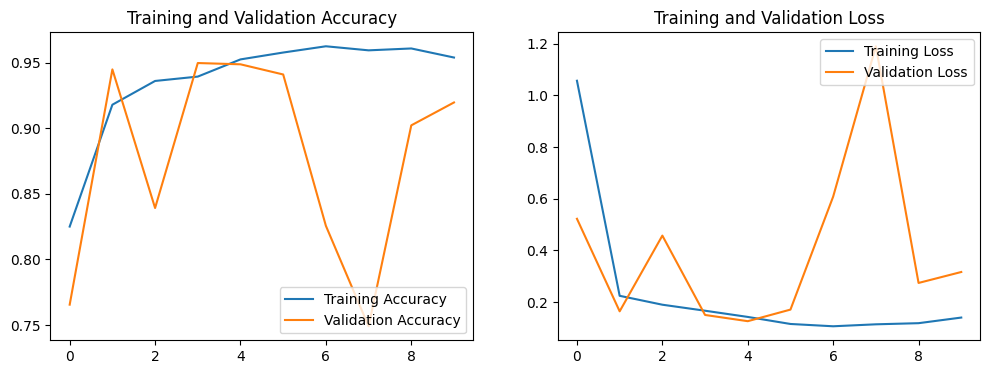

In [6]:
import matplotlib.pyplot as plt

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(val_ds)
print(f"\nValidation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **6. Results Interpretation**

**Key Points**

- **Validation Accuracy = 91.28%**
  
  - The model correctly predicts NORMAL vs PNEUMONIA with high reliability.
- **Validation Loss = 0.3996**
  
  - Low error → predictions are generally close to the truth.
- **Time per Step = 273 ms**
  
  - Efficient evaluation speed.


The numerical evaluation gives us a clear summary of the model’s performance on unseen images. With a validation accuracy of **91.28%**, the model demonstrates strong ability to distinguish between NORMAL and PNEUMONIA cases. The validation loss of **0.3996** reflects a relatively low error rate, which confirms that the predictions are consistent and stable. Finally, the model processes each batch in about **273 milliseconds**, which is efficient and practical for real-world deployment.



### **Training History Interpretation**

#### **A. Accuracy Curve Analysis**

**Key Points**

- Training accuracy rises smoothly and reaches **>96%**.
  
- Validation accuracy is highly unstable.
  
- Sharp drop between epochs **5 and 7** → sign of overfitting.
  
- Ends at a stable **91.28%**.
  

The accuracy plot tells a very clear story. The model learns the training data extremely well, climbing above **96%** accuracy. However, the validation accuracy behaves unpredictably—it rises fast, then drops sharply around epochs **5 to 7**, before recovering. This instability indicates **overfitting**, meaning the model memorizes the training data instead of learning general patterns. Even though the final validation accuracy is strong, the fluctuations show that the model struggles to generalize consistently.


#### **B. Loss Curve Analysis**

**Key Points**

- Training loss drops to a very low value.
  
- Validation loss is highly erratic with large spikes.
  
- Big gap between training and validation loss → **severe overfitting**.
  


The loss curve confirms the earlier observation. While the training loss quickly becomes very low—showing excellent fit—the validation loss fluctuates heavily, with sudden spikes above **1.0**. This mismatch between the two curves is a classic signature of **severe overfitting**. The model performs extremely well on the data it has seen, but struggles on new data.



#### **Summary & Recommendations**

**Key Points**

- Strong final accuracy: **91.28%**.
  
- Training history shows **instability** and **overfitting**.
  
- Several improvements can stabilize and enhance performance:
  
  - Early stopping
    
  - More regularization
    
  - Stronger data augmentation
    
  - Learning-rate scheduling
    

Although the final accuracy is impressive, the training history reveals that the model does not generalize smoothly. The instability and large gap between training and validation results indicate **overfitting**. To solve this, we can introduce early stopping around epoch 4–5, increase regularization, strengthen data augmentation, and use a learning-rate schedule. These improvements will reduce overfitting and help the model achieve both higher accuracy and greater stability.